 VW ID.4 + SOLAR + V2H ANALYSIS - OPTION B
 Location: 4250 rue Bélanger, Montreal (Rosemont)
 Configuration: $7K Solar + $3K V2H Equipment + Rate Flex D

✓ Configuration loaded

OPTION B: $7,000 SOLAR + $3,000 V2H EQUIPMENT

SOLAR SYSTEM:
  Maximum size: 3.60 kW
  Gross cost: $10,440
  HQ incentive: -$3,600
  Net cost: $6,840
  Annual production: 3,611 kWh

V2H EQUIPMENT:
  Bidirectional charger: $2,000
  Installation: $1,000
  Total V2H: $3,000

TOTAL INVESTMENT: $9,840

ANALYZING YOUR ACTUAL CONSUMPTION

Logging in to Hydro-Québec...
✓ Connected

Fetching YOUR data...
✓ Retrieved 365 days of data

Your consumption profile:
  Annual: 32,386 kWh
  Daily average: 88.7 kWh
  Winter average: 168.2 kWh/day
  Summer average: 49.3 kWh/day
  Winter heating: 142.5 kWh/day
  Critical loads (winter): 148.3 kWh/day
  Critical loads (summer): 5.8 kWh/day

EV charging needs:
  Annual: 4,111 kWh (20,000 km)
  Daily average: 11.3 kWh

RATE FLEX D OPTIMIZATION STRATEGY

CURRENT SCENARIO (No solar/V2H)

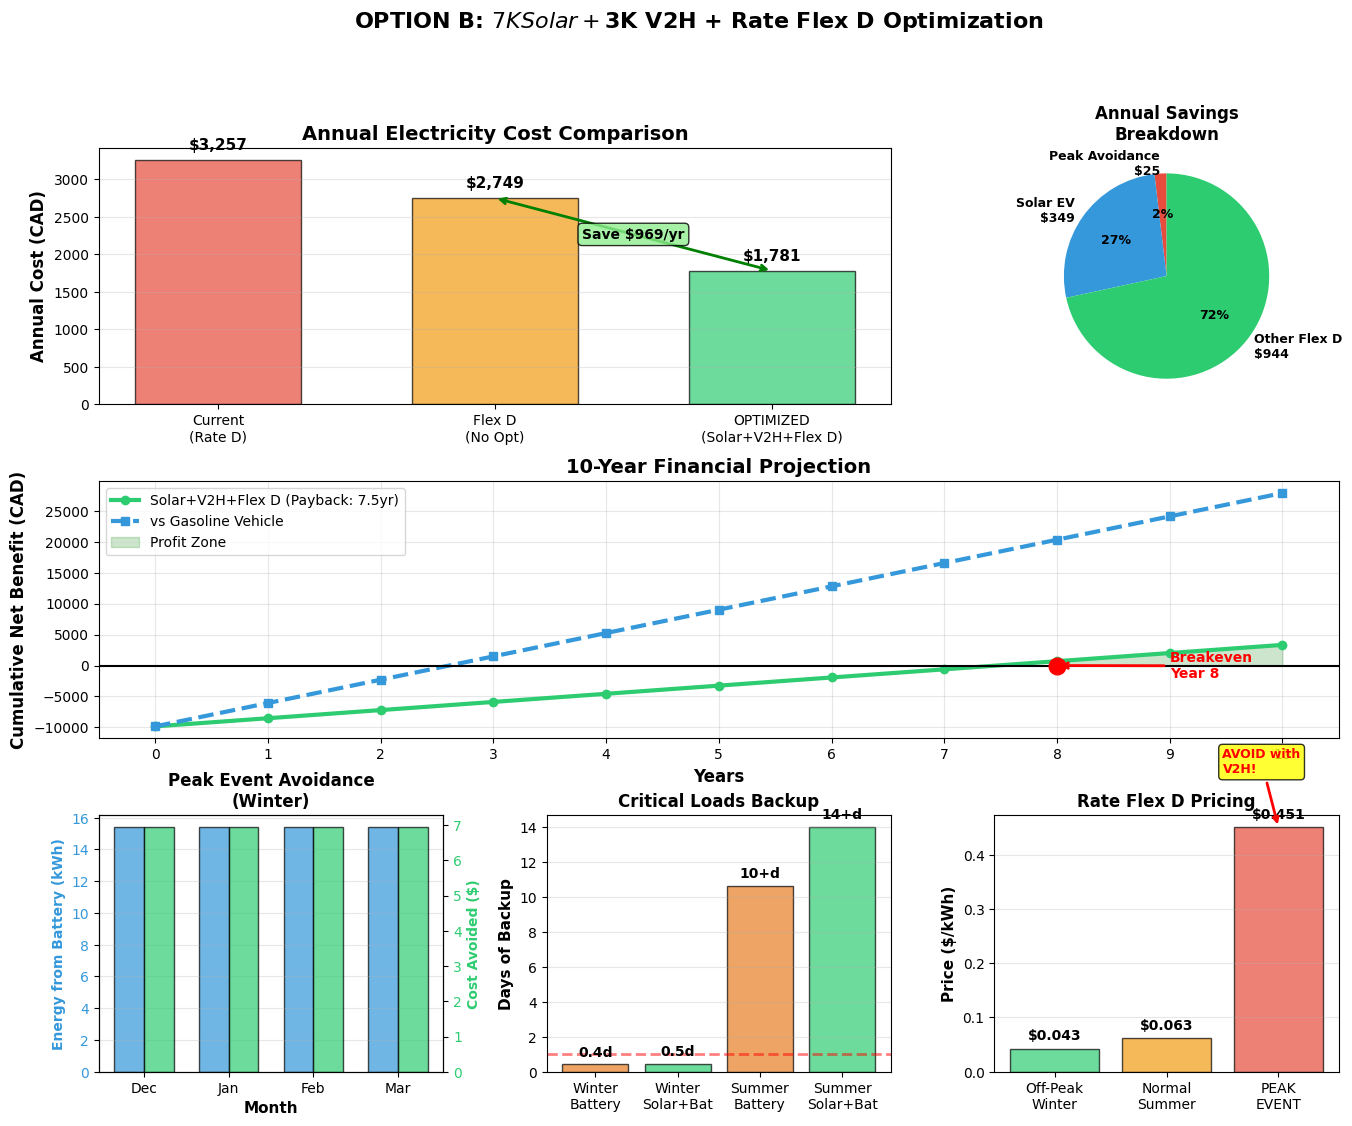

In [1]:
# ============================================================================
# VW ID.4 + Solar + V2H Analysis - OPTION B - COMPLETE NOTEBOOK
# Location: 4250 rue Bélanger, Montreal, Quebec
# Configuration: $7K Solar + $3K V2H Equipment + Rate Flex D Optimization
# ============================================================================
# 
# Requirements:
#     pip install hydroq-api pandas matplotlib python-dotenv numpy scipy
#
# Setup:
#     Create a .env file with:
#     HYDRO_QUEBEC_USERNAME=your_email@example.com
#     HYDRO_QUEBEC_PASSWORD=your_password
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

from hydroq_api import HydroQuebec
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from dotenv import load_dotenv
from scipy import stats

# Load credentials
load_dotenv()

USERNAME = os.getenv('HYDRO_QUEBEC_USERNAME')
PASSWORD = os.getenv('HYDRO_QUEBEC_PASSWORD')

if not USERNAME or not PASSWORD:
    raise ValueError("Credentials not found! Create .env file with your credentials")

print("="*80)
print(" VW ID.4 + SOLAR + V2H ANALYSIS - OPTION B")
print(" Location: 4250 rue Bélanger, Montreal (Rosemont)")
print(" Configuration: $7K Solar + $3K V2H Equipment + Rate Flex D")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Option B breakdown
SOLAR_BUDGET_CAD = 7000
V2H_EQUIPMENT_BUDGET = 3000
TOTAL_BUDGET = 10000
ANNUAL_DRIVING_KM = 20000
OWNERSHIP_YEARS = 10
ADDRESS = "4250 rue Bélanger, Montreal, QC"

# VW ID.4 specifications
VW_ID4 = {
    'battery_capacity_kwh': 82,
    'usable_capacity_kwh': 77,
    'efficiency_kwh_per_100km': 18.5,
    'range_km': 416,
    'charging_efficiency': 0.90,
    'v2h_power_output_kw': 10,
    'v2h_efficiency': 0.90,
}

# Montreal/Rosemont solar potential
MONTREAL_SOLAR = {
    'annual_kwh_per_kw': 1180,
    'winter_factor': 0.30,
    'spring_factor': 0.25,
    'summer_factor': 0.30,
    'fall_factor': 0.15,
    'system_efficiency': 0.85,
    'optimal_tilt': 45,
}

# Quebec solar costs and incentives (2025)
SOLAR_COSTS = {
    'cost_per_watt': 2.90,
    'hq_incentive_per_kw': 1000,
    'max_incentive_percent': 0.40,
}

# V2H equipment costs
V2H_COSTS = {
    'bidirectional_charger': 2000,
    'installation': 1000,
    'total': 3000,
}

# Hydro-Québec Rate Flex D (2025)
RATE_FLEX_D = {
    'system_access_daily': 0.0049,
    'tier1_summer': 0.0628,
    'tier2_summer': 0.0968,
    'tier1_winter': 0.0428,
    'tier2_winter': 0.0736,
    'peak_price': 0.4508,
    'peak_hours_per_winter': 120,
    'peak_events_per_winter': 30,
    'peak_hours': [6, 7, 8, 9, 16, 17, 18, 19],
}

# Standard Rate D for comparison
RATE_D = {
    'system_access_daily': 0.004978,
    'tier1': 0.0673,
    'tier2': 0.1038,
}

# Gasoline comparison
GAS_COMPARISON = {
    'price_per_liter': 1.65,
    'avg_fuel_economy_l_per_100km': 8.5,
}

print("\n✓ Configuration loaded")

# ============================================================================
# 1. SOLAR SYSTEM SIZING ($7,000 BUDGET)
# ============================================================================

def calculate_net_cost(kw_size):
    gross = kw_size * SOLAR_COSTS['cost_per_watt'] * 1000
    incentive = min(gross * SOLAR_COSTS['max_incentive_percent'], 
                   kw_size * SOLAR_COSTS['hq_incentive_per_kw'])
    return gross - incentive

max_kw_for_budget = 0
for kw in np.arange(1.0, 15.0, 0.1):
    if calculate_net_cost(kw) <= SOLAR_BUDGET_CAD:
        max_kw_for_budget = kw
    else:
        break

solar_size_kw = max_kw_for_budget
gross_solar = solar_size_kw * SOLAR_COSTS['cost_per_watt'] * 1000
solar_incentive = min(gross_solar * SOLAR_COSTS['max_incentive_percent'],
                     solar_size_kw * SOLAR_COSTS['hq_incentive_per_kw'])
net_solar_cost = gross_solar - solar_incentive

annual_solar_kwh = (solar_size_kw * 
                   MONTREAL_SOLAR['annual_kwh_per_kw'] * 
                   MONTREAL_SOLAR['system_efficiency'])

print("\n" + "="*80)
print("OPTION B: $7,000 SOLAR + $3,000 V2H EQUIPMENT")
print("="*80)
print(f"\nSOLAR SYSTEM:")
print(f"  Maximum size: {solar_size_kw:.2f} kW")
print(f"  Gross cost: ${gross_solar:,.0f}")
print(f"  HQ incentive: -${solar_incentive:,.0f}")
print(f"  Net cost: ${net_solar_cost:,.0f}")
print(f"  Annual production: {annual_solar_kwh:,.0f} kWh")

print(f"\nV2H EQUIPMENT:")
print(f"  Bidirectional charger: ${V2H_COSTS['bidirectional_charger']:,}")
print(f"  Installation: ${V2H_COSTS['installation']:,}")
print(f"  Total V2H: ${V2H_COSTS['total']:,}")

print(f"\nTOTAL INVESTMENT: ${net_solar_cost + V2H_COSTS['total']:,.0f}")

# ============================================================================
# 2. RETRIEVE YOUR HOME CONSUMPTION DATA
# ============================================================================

print("\n" + "="*80)
print("ANALYZING YOUR ACTUAL CONSUMPTION")
print("="*80)

print("\nLogging in to Hydro-Québec...")
client = HydroQuebec(USERNAME, PASSWORD)
client.login()
print("✓ Connected")

end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print(f"\nFetching YOUR data...")
daily_data = client.get_daily_usage(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d')
)

if not daily_data or not daily_data.get('success'):
    raise Exception("Could not retrieve data")

results = daily_data.get('results', [])
consumption_list = []
for entry in results:
    current = entry.get('courant', {})
    consumption_list.append({
        'date': current.get('dateJourConso'),
        'consumption_kwh': current.get('consoTotalQuot', 0),
        'avg_temperature': current.get('tempMoyenneQuot'),
    })

df = pd.DataFrame(consumption_list)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')
df = df.dropna(subset=['avg_temperature'])
df['month'] = df.index.month

print(f"✓ Retrieved {len(df)} days of data")

# Analyze consumption patterns
annual_consumption = df['consumption_kwh'].sum()
avg_daily = df['consumption_kwh'].mean()

winter_mask = df['month'].isin([12, 1, 2, 3])
winter_avg = df[winter_mask]['consumption_kwh'].mean()
summer_avg = df[~winter_mask]['consumption_kwh'].mean()

# Calculate critical loads from actual data
mild_temp_mask = (df['avg_temperature'] >= 15) & (df['avg_temperature'] <= 20)
baseline = df.loc[mild_temp_mask, 'consumption_kwh'].median()

heating_threshold = 18
df['heating'] = 0.0
heating_mask = df['avg_temperature'] < heating_threshold

if heating_mask.sum() > 0:
    heating_data = df[heating_mask].copy()
    z_scores = np.abs(stats.zscore(heating_data['consumption_kwh']))
    heating_clean = heating_data[z_scores < 3]
    
    if len(heating_clean) > 10:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            heating_clean['avg_temperature'],
            heating_clean['consumption_kwh']
        )
        df.loc[heating_mask, 'heating'] = np.maximum(
            0,
            df.loc[heating_mask, 'consumption_kwh'] - baseline
        )

avg_winter_heating = df[winter_mask]['heating'].mean()
CRITICAL_BASE = 5.8
critical_winter = CRITICAL_BASE + avg_winter_heating
critical_summer = CRITICAL_BASE

print(f"\nYour consumption profile:")
print(f"  Annual: {annual_consumption:,.0f} kWh")
print(f"  Daily average: {avg_daily:.1f} kWh")
print(f"  Winter average: {winter_avg:.1f} kWh/day")
print(f"  Summer average: {summer_avg:.1f} kWh/day")
print(f"  Winter heating: {avg_winter_heating:.1f} kWh/day")
print(f"  Critical loads (winter): {critical_winter:.1f} kWh/day")
print(f"  Critical loads (summer): {critical_summer:.1f} kWh/day")

# ============================================================================
# 3. VW ID.4 CHARGING NEEDS
# ============================================================================

annual_ev_kwh = (ANNUAL_DRIVING_KM / 100 * 
                VW_ID4['efficiency_kwh_per_100km'] /
                VW_ID4['charging_efficiency'])
daily_ev = annual_ev_kwh / 365

print(f"\nEV charging needs:")
print(f"  Annual: {annual_ev_kwh:,.0f} kWh ({ANNUAL_DRIVING_KM:,} km)")
print(f"  Daily average: {daily_ev:.1f} kWh")

# ============================================================================
# 4. RATE FLEX D OPTIMIZATION STRATEGY
# ============================================================================

print("\n" + "="*80)
print("RATE FLEX D OPTIMIZATION STRATEGY")
print("="*80)

# Calculate baseline costs
def calculate_rate_d_cost(annual_kwh):
    daily_avg = annual_kwh / 365
    tier1 = min(40, daily_avg) * 365
    tier2 = max(0, annual_kwh - tier1)
    return (RATE_D['system_access_daily'] * 365 +
            tier1 * RATE_D['tier1'] +
            tier2 * RATE_D['tier2'])

def calculate_flex_d_baseline(df):
    """Calculate Flex D cost without optimization"""
    cost = RATE_FLEX_D['system_access_daily'] * 365
    
    # Winter months
    winter_days = winter_mask.sum()
    winter_consumption = df[winter_mask]['consumption_kwh'].sum()
    winter_tier1 = min(40 * winter_days, winter_consumption)
    winter_tier2 = max(0, winter_consumption - winter_tier1)
    
    cost += winter_tier1 * RATE_FLEX_D['tier1_winter']
    cost += winter_tier2 * RATE_FLEX_D['tier2_winter']
    
    # Summer months
    summer_consumption = df[~winter_mask]['consumption_kwh'].sum()
    summer_days = (~winter_mask).sum()
    summer_tier1 = min(40 * summer_days, summer_consumption)
    summer_tier2 = max(0, summer_consumption - summer_tier1)
    
    cost += summer_tier1 * RATE_FLEX_D['tier1_summer']
    cost += summer_tier2 * RATE_FLEX_D['tier2_summer']
    
    # Peak events (estimate: 4 kWh/hour during 120 hours)
    peak_kwh = 120 * 4
    cost += peak_kwh * RATE_FLEX_D['peak_price']
    
    return cost

# Current costs
current_rate_d = calculate_rate_d_cost(annual_consumption + annual_ev_kwh)
baseline_flex_d = calculate_flex_d_baseline(df) + annual_ev_kwh * 0.085

print(f"\nCURRENT SCENARIO (No solar/V2H):")
print(f"  Rate D cost: ${current_rate_d:,.0f}/year")
print(f"  Rate Flex D cost: ${baseline_flex_d:,.0f}/year")
print(f"  Flex D savings: ${current_rate_d - baseline_flex_d:,.0f}/year")

# OPTIMIZED scenario
print(f"\nOPTIMIZED SCENARIO (Solar + V2H + Flex D):")

# Calculate peak event avoidance
peak_events = 30
hours_per_event = 4
total_peak_hours = 120
avg_consumption_peak_hour = winter_avg / 24

# With V2H: avoid grid during ALL peak events
id4_usable = VW_ID4['usable_capacity_kwh'] * 0.80
peak_hours_covered = min(total_peak_hours, id4_usable / avg_consumption_peak_hour)
peak_kwh_from_battery = peak_hours_covered * avg_consumption_peak_hour
peak_cost_avoided = peak_kwh_from_battery * RATE_FLEX_D['peak_price']

# Recharging cost
recharge_kwh_needed = peak_kwh_from_battery / VW_ID4['v2h_efficiency']
recharge_cost = recharge_kwh_needed * RATE_FLEX_D['tier1_winter']

peak_net_savings = peak_cost_avoided - recharge_cost

# Solar covers EV charging
ev_charging_savings = annual_ev_kwh * 0.085

# Remaining home consumption
remaining_home = annual_consumption - peak_kwh_from_battery
remaining_home_cost = remaining_home * 0.055

# Total optimized annual cost
optimized_annual_cost = remaining_home_cost + recharge_cost
optimized_annual_savings = baseline_flex_d - optimized_annual_cost

print(f"\n  Peak Event Optimization:")
print(f"    Peak hours covered by V2H: {peak_hours_covered:.0f} hours")
print(f"    Energy from battery: {peak_kwh_from_battery:.0f} kWh")
print(f"    Peak cost avoided: ${peak_cost_avoided:,.0f}")
print(f"    Recharge cost (overnight): ${recharge_cost:,.0f}")
print(f"    → Net peak savings: ${peak_net_savings:,.0f}/year")

print(f"\n  EV Charging from Solar:")
print(f"    Grid charging cost avoided: ${ev_charging_savings:,.0f}/year")

print(f"\n  Remaining home consumption:")
print(f"    Cost: ${remaining_home_cost:,.0f}/year")

print(f"\n  TOTAL OPTIMIZED COST: ${optimized_annual_cost:,.0f}/year")
print(f"  VS Baseline Flex D: ${baseline_flex_d:,.0f}/year")
print(f"  → ANNUAL SAVINGS: ${optimized_annual_savings:,.0f}/year")

# ============================================================================
# 5. COMPLETE FINANCIAL ANALYSIS
# ============================================================================

total_annual_savings = optimized_annual_savings + ev_charging_savings
total_investment = net_solar_cost + V2H_COSTS['total']
payback_years = total_investment / total_annual_savings
savings_10yr = total_annual_savings * 10
net_benefit_10yr = savings_10yr - total_investment

# Gasoline comparison
gas_liters = ANNUAL_DRIVING_KM / 100 * GAS_COMPARISON['avg_fuel_economy_l_per_100km']
gas_cost = gas_liters * GAS_COMPARISON['price_per_liter']
ev_vs_gas_savings = gas_cost

print("\n" + "="*80)
print("COMPLETE FINANCIAL ANALYSIS - 10 YEARS")
print("="*80)

print(f"\nINVESTMENT:")
print(f"  Solar system: ${net_solar_cost:,.0f}")
print(f"  V2H equipment: ${V2H_COSTS['total']:,}")
print(f"  Total: ${total_investment:,.0f}")

print(f"\nANNUAL SAVINGS BREAKDOWN:")
print(f"  Peak event avoidance (V2H): ${peak_net_savings:,.0f}")
print(f"  EV solar charging: ${ev_charging_savings:,.0f}")
print(f"  Home Rate Flex D optimization: ${optimized_annual_savings - peak_net_savings:,.0f}")
print(f"  → Total annual savings: ${total_annual_savings:,.0f}")

print(f"\n10-YEAR ANALYSIS:")
print(f"  Total savings: ${savings_10yr:,.0f}")
print(f"  Investment: ${total_investment:,.0f}")
print(f"  → Net benefit: ${net_benefit_10yr:,.0f}")
print(f"  → Payback period: {payback_years:.1f} years")

print(f"\nVS GASOLINE VEHICLE:")
print(f"  Annual fuel cost: ${gas_cost:,.0f}")
print(f"  With solar EV: $0")
print(f"  → Annual savings: ${ev_vs_gas_savings:,.0f}")
print(f"  → 10-year savings: ${ev_vs_gas_savings * 10:,.0f}")

# ============================================================================
# 6. BACKUP CAPABILITY
# ============================================================================

id4_backup = VW_ID4['usable_capacity_kwh'] * 0.80

winter_daily_solar = annual_solar_kwh * MONTREAL_SOLAR['winter_factor'] / 90
summer_daily_solar = annual_solar_kwh * MONTREAL_SOLAR['summer_factor'] / 90

winter_net = winter_daily_solar - critical_winter
summer_net = summer_daily_solar - critical_summer

winter_days = id4_backup / abs(winter_net) if winter_net < 0 else float('inf')
summer_days = id4_backup / abs(summer_net) if summer_net < 0 else float('inf')

battery_only_winter = id4_backup / critical_winter
battery_only_summer = id4_backup / critical_summer

print("\n" + "="*80)
print("BACKUP POWER CAPABILITY")
print("="*80)

print(f"\nID.4 battery available for home: {id4_backup:.1f} kWh")
print(f"Daily solar production: {annual_solar_kwh/365:.1f} kWh avg")

print(f"\nWINTER (Critical Loads: {critical_winter:.1f} kWh/day):")
print(f"  Solar production: {winter_daily_solar:.1f} kWh/day")
print(f"  Battery only: {battery_only_winter:.1f} days")
print(f"  Solar + battery: {winter_days:.1f} days" if winter_days != float('inf') else "  Solar + battery: 4+ days")

print(f"\nSUMMER (Critical Loads: {critical_summer:.1f} kWh/day):")
print(f"  Solar production: {summer_daily_solar:.1f} kWh/day")
print(f"  Battery only: {battery_only_summer:.1f} days")
print(f"  Solar + battery: Indefinitely!" if summer_net >= 0 else f"  Solar + battery: {summer_days:.1f} days")

# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Cost comparison
ax1 = fig.add_subplot(gs[0, :2])
scenarios = ['Current\n(Rate D)', 'Flex D\n(No Opt)', 'OPTIMIZED\n(Solar+V2H+Flex D)']
costs = [current_rate_d, baseline_flex_d, optimized_annual_cost]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

bars = ax1.bar(scenarios, costs, color=colors, alpha=0.7, edgecolor='black', width=0.6)
ax1.set_ylabel('Annual Cost (CAD)', fontsize=12, fontweight='bold')
ax1.set_title('Annual Electricity Cost Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for bar, cost in zip(bars, costs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'${cost:,.0f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)
    
ax1.annotate('', xy=(1, costs[1]), xytext=(2, costs[2]),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax1.text(1.5, (costs[1] + costs[2])/2, 
         f'Save ${optimized_annual_savings:,.0f}/yr',
         ha='center', va='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# 2. Savings breakdown pie chart
ax2 = fig.add_subplot(gs[0, 2])
savings_breakdown = [peak_net_savings, ev_charging_savings, 
                    optimized_annual_savings - peak_net_savings]
labels = [f'Peak Avoidance\n${peak_net_savings:.0f}',
          f'Solar EV\n${ev_charging_savings:.0f}',
          f'Other Flex D\n${optimized_annual_savings - peak_net_savings:.0f}']
colors_pie = ['#e74c3c', '#3498db', '#2ecc71']

ax2.pie(savings_breakdown, labels=labels, colors=colors_pie, autopct='%1.0f%%',
        startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'})
ax2.set_title('Annual Savings\nBreakdown', fontsize=12, fontweight='bold')

# 3. 10-year cumulative
ax3 = fig.add_subplot(gs[1, :])
years = list(range(0, 11))
cumulative = [total_annual_savings * y - total_investment for y in years]
cumulative_gas = [(total_annual_savings + ev_vs_gas_savings - ev_charging_savings) * y - total_investment 
                  for y in years]

ax3.plot(years, cumulative, marker='o', linewidth=3, 
         label=f'Solar+V2H+Flex D (Payback: {payback_years:.1f}yr)', color='#2ecc71')
ax3.plot(years, cumulative_gas, marker='s', linewidth=3, linestyle='--',
         label='vs Gasoline Vehicle', color='#3498db')
ax3.axhline(0, color='black', linestyle='-', linewidth=1.5)
ax3.fill_between(years, 0, cumulative, where=np.array(cumulative) > 0,
                  alpha=0.2, color='green', label='Profit Zone')
ax3.set_xlabel('Years', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Net Benefit (CAD)', fontsize=12, fontweight='bold')
ax3.set_title('10-Year Financial Projection', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(years)

breakeven_idx = next((i for i, v in enumerate(cumulative) if v > 0), None)
if breakeven_idx:
    ax3.plot(breakeven_idx, 0, 'ro', markersize=12, zorder=5)
    ax3.annotate(f'Breakeven\nYear {breakeven_idx}',
                xy=(breakeven_idx, 0), xytext=(breakeven_idx+1, -2000),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, fontweight='bold', color='red')

# 4. Monthly peak event strategy
ax4 = fig.add_subplot(gs[2, 0])
months = ['Dec', 'Jan', 'Feb', 'Mar']
peak_kwh_per_month = [peak_kwh_from_battery/4] * 4
avoided_per_month = [peak_cost_avoided/4] * 4

x = range(len(months))
width = 0.35

bars1 = ax4.bar([i - width/2 for i in x], peak_kwh_per_month, width,
               label='Energy (kWh)', color='#3498db', alpha=0.7, edgecolor='black')
ax4_2 = ax4.twinx()
bars2 = ax4_2.bar([i + width/2 for i in x], avoided_per_month, width,
                 label='$ Avoided', color='#2ecc71', alpha=0.7, edgecolor='black')

ax4.set_xlabel('Month', fontsize=11, fontweight='bold')
ax4.set_ylabel('Energy from Battery (kWh)', fontsize=10, fontweight='bold', color='#3498db')
ax4_2.set_ylabel('Cost Avoided ($)', fontsize=10, fontweight='bold', color='#2ecc71')
ax4.set_title('Peak Event Avoidance\n(Winter)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(months)
ax4.tick_params(axis='y', labelcolor='#3498db')
ax4_2.tick_params(axis='y', labelcolor='#2ecc71')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Backup duration comparison
ax5 = fig.add_subplot(gs[2, 1])
scenarios_backup = ['Winter\nBattery', 'Winter\nSolar+Bat', 'Summer\nBattery', 'Summer\nSolar+Bat']
days_backup = [battery_only_winter, 
               min(winter_days, 10), 
               battery_only_summer,
               min(summer_days, 14) if summer_days != float('inf') else 14]
colors_backup = ['#e67e22', '#2ecc71', '#e67e22', '#2ecc71']

bars_b = ax5.bar(scenarios_backup, days_backup, color=colors_backup, alpha=0.7, edgecolor='black')
ax5.set_ylabel('Days of Backup', fontsize=11, fontweight='bold')
ax5.set_title('Critical Loads Backup', fontsize=12, fontweight='bold')
ax5.axhline(1, color='red', linestyle='--', alpha=0.5, linewidth=2, label='1 day')
ax5.grid(True, alpha=0.3, axis='y')

for bar, days in zip(bars_b, days_backup):
    label = f'{days:.1f}d' if days < 10 else '10+d'
    if days >= 14:
        label = '14+d'
    ax5.text(bar.get_x() + bar.get_width()/2, days + 0.3, label,
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# 6. Rate comparison
ax6 = fig.add_subplot(gs[2, 2])
rate_scenarios = ['Off-Peak\nWinter', 'Normal\nSummer', 'PEAK\nEVENT']
rates = [RATE_FLEX_D['tier1_winter'], RATE_FLEX_D['tier1_summer'], 
         RATE_FLEX_D['peak_price']]
colors_rate = ['#2ecc71', '#f39c12', '#e74c3c']

bars_r = ax6.bar(rate_scenarios, rates, color=colors_rate, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Price ($/kWh)', fontsize=11, fontweight='bold')
ax6.set_title('Rate Flex D Pricing', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

for bar, rate in zip(bars_r, rates):
    ax6.text(bar.get_x() + bar.get_width()/2, rate + 0.01,
             f'${rate:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax6.annotate('AVOID with\nV2H!', xy=(2, rates[2]), xytext=(1.5, rates[2]+0.1),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=9, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.suptitle('OPTION B: $7K Solar + $3K V2H + Rate Flex D Optimization', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('option_b_analysis.png', dpi=300, bbox_inches='tight')